In [ ]:
# Copyright 2016 The TensorFlow Authors. All Rights Reserved.
# Taken from tensorflow/tensorflow/blob/master/tensorflow/contrib/learn/python/learn/datasets/mnist.py
# Changed by fjhheras@gmail.com for his own fishy purposes 
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================

In [120]:
"""Functions for reading fishyfish data."""

from PIL import Image
import PIL

# image processing
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from scipy import misc # probably won't be needed
from PIL import Image
import PIL

# calculations
import numpy as np
import tensorflow as tf

# os tools / directories and memory check
import os
import sys
import collections

%matplotlib inline

In [121]:
folder = '/Users/indp/Dropbox/rotations/polavieja/data/good_datasets/isic-archive_ss/'
path_melanoma = '/Users/indp/Dropbox/rotations/polavieja/data/good_datasets/isic-archive_ss/melanoma/'
path_non_melanoma = '/Users/indp/Dropbox/rotations/polavieja/data/good_datasets/isic-archive_ss/non_melanoma/'
img_names = os.listdir(folder)
img_name_cls = load_cancer_data_labels(path_melanoma, path_non_melanoma)
img_path = '/Users/indp/Dropbox/rotations/polavieja/data/good_datasets/isic-archive_ss/all/'

In [127]:
def plot_images(images, sq_size):
    #assert len(images) == len(cls_true) == 9
    
    # Create figure with 3x3 sub-plots.
    fig, axes = plt.subplots(sq_size, sq_size)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    images = images[0:sq_size**2]
    
    for i, ax in enumerate(axes.flat):
        # Plot image.
        ax.imshow(images[i], cmap='gray')
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

In [123]:
def load_cancer_data_labels(path_melanoma, path_non_melanoma):
    # returns a list of filenames with the corresponding class
    # 1 for melanoma, 0 for non-melanoma
    
    img_melanoma = []
    img_non_melanoma = []

    for (dirpath, dirnames, filenames) in os.walk(path_melanoma):
        img_melanoma.extend(filenames)
        break

    for (dirpath, dirnames, filenames) in os.walk(path_non_melanoma):
        img_non_melanoma.extend(filenames)
        break

    del(img_melanoma[0])
    del(img_non_melanoma[0])

    # one hot encoding should be in this vector?
    # [1,0], [0,1] vectors?

    img_name_cls = []
    for e in img_melanoma:
        img_name_cls.append(np.array([e, int(1)]))
    for e in img_non_melanoma:
        img_name_cls.append(np.array([e, int(0)]))
    img_name_cls = np.asarray(img_name_cls)
    
    return img_name_cls

In [124]:
def get_expected_size(img_name_cls):
    # loads first 3 images and checks if size is the same
    # uses that as the size of all the images
    test_shape = []
    c = 0
    for e in img_name_cls:
        test_shape.append(np.asarray(Image.open(img_path + e[0]).convert('L')).shape)
        c+=1
        if c > 4:
            break
    test_shape = np.asarray(test_shape)
    
    if  np.all(test_shape[0] == test_shape):
        return img_shape
    else:
        print('Size is not consistent')
        return (0,0)
    return (0,0)

In [166]:
def dense_to_one_hot(labels_dense, num_classes):
    """Convert class labels from scalars to one-hot vectors."""
    num_labels = labels_dense.shape[0]
    index_offset = np.arange(num_labels) * num_classes
    labels_one_hot = np.zeros((num_labels, num_classes))
    labels_one_hot.flat[index_offset + labels_dense.ravel()] = 1
    return labels_one_hot

In [209]:
def extract_labels(folder, num_classes, img_index):
    img_name_cls = load_cancer_data_labels(path_melanoma, path_non_melanoma)
    labels_dense = img_name_cls[:,1].astype(int)
    labels_dense = labels_dense[img_index]
    return dense_to_one_hot(labels_dense, num_classes)

In [200]:
def extract_images(folder):
    """
    Extract the images into a 3D numpy array [index, y, x].
    Args:
      f: A file object that can be passed into a gzip reader.
    Returns:
      data: A 3D float32 numpy array [index, y, x, depth].
      
      This is constructed for a 2 class cancer image dataset, 
      melanoma and non-melanoma.
    """
    PX_DEPTH = 255.0 # number of values in the grayscale - used to normalise the images
    
    path_melanoma = folder + 'melanoma/'
    path_non_melanoma = folder + 'non_melanoma/'
    img_path = folder+'all/'
    
    img_name_cls = load_cancer_data_labels(path_melanoma, path_non_melanoma)
    
    (height,width) = get_expected_size(img_name_cls)
    print('Chosen size of the image:', (height,width))

    total_images = img_name_cls.shape[0]
    
    dataset = np.ndarray(shape=(img_name_cls.shape[0], height,width),
                         dtype=np.float32)
    image_index = 0
    extracted_img_ind = []
    for i,e in enumerate(img_name_cls):
        #image_file = os.path.join(folder, image)
        try:
            #print(img_path + e[0])
            image_data = np.asarray(Image.open(img_path + e[0]).convert('L'))
            image_data = (image_data.astype(np.float32) )/ PX_DEPTH #normalize images
                    #- PX_DEPTH / 2) / PX_DEPTH
            
            if image_data.shape == (width,height):
                image_data = image_data.T
                
            if image_data.shape != (height,width):
                #raise Exception('Unexpected image shape: {} instead of {}'.format(image_data.shape,(height,width)))
                #print('different sizes', image_data.shape, (height,width))
                continue
            
            dataset[image_index, :, :] = image_data
            image_index += 1
            extracted_img_ind.append(i)
            print("\r", 'Progress: ', i/float(total_images), end='')
            
        except IOError as d: # does not block the progression of the loop
            print('Could not read file - it\'s ok, skipping.')
    
    num_images = image_index
    extracted_img_ind = np.asarray(extracted_img_ind)
    print("Extracting {} images from folder '{}'".format(num_images,folder))
    dataset = dataset[0:num_images, :, :]
    print('Extracted index size: ', extracted_img_ind.shape)

    return dataset, extracted_img_ind #.astype(np.float32)

In [201]:
a, b = extract_images(folder)

Chosen size of the image: (448, 598)
 Progress:  0.8403421240199572Extracting 1842 images from folder '/Users/indp/Dropbox/rotations/polavieja/data/good_datasets/isic-archive_ss/'
Extracted index size:  (1842,)


In [219]:
dl = extract_labels(folder, 2, b)

In [213]:
img_name_cls = load_cancer_data_labels(path_melanoma, path_non_melanoma)

In [222]:
for i,e in enumerate(b):
    print(img_name_cls[e], dl[i])

['ISIC_0000002.jpg' '1'] [ 0.  1.]
['ISIC_0000004.jpg' '1'] [ 0.  1.]
['ISIC_0000013.jpg' '1'] [ 0.  1.]
['ISIC_0000022.jpg' '1'] [ 0.  1.]
['ISIC_0000026.jpg' '1'] [ 0.  1.]
['ISIC_0000029.jpg' '1'] [ 0.  1.]
['ISIC_0000031.jpg' '1'] [ 0.  1.]
['ISIC_0000035.jpg' '1'] [ 0.  1.]
['ISIC_0000036.jpg' '1'] [ 0.  1.]
['ISIC_0000040.jpg' '1'] [ 0.  1.]
['ISIC_0000043.jpg' '1'] [ 0.  1.]
['ISIC_0000046.jpg' '1'] [ 0.  1.]
['ISIC_0000049.jpg' '1'] [ 0.  1.]
['ISIC_0000054.jpg' '1'] [ 0.  1.]
['ISIC_0000056.jpg' '1'] [ 0.  1.]
['ISIC_0000070.jpg' '1'] [ 0.  1.]
['ISIC_0000074.jpg' '1'] [ 0.  1.]
['ISIC_0000076.jpg' '1'] [ 0.  1.]
['ISIC_0000078.jpg' '1'] [ 0.  1.]
['ISIC_0000139.jpg' '1'] [ 0.  1.]
['ISIC_0000140.jpg' '1'] [ 0.  1.]
['ISIC_0000141.jpg' '1'] [ 0.  1.]
['ISIC_0000142.jpg' '1'] [ 0.  1.]
['ISIC_0000143.jpg' '1'] [ 0.  1.]
['ISIC_0000144.jpg' '1'] [ 0.  1.]
['ISIC_0000145.jpg' '1'] [ 0.  1.]
['ISIC_0000146.jpg' '1'] [ 0.  1.]
['ISIC_0000147.jpg' '1'] [ 0.  1.]
['ISIC_0000148.jpg' 

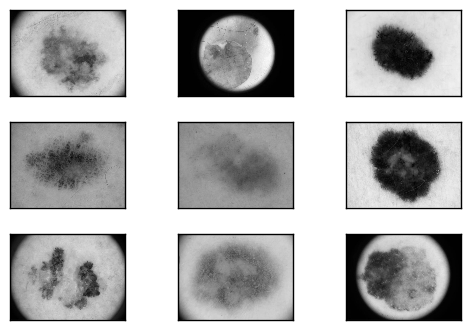

In [133]:
plot_images(dset, 3)

In [193]:
class DataSet(object):

    def __init__(self,
               images,
               labels,
               reshape=False):
        """Construct a DataSet.
        """
        # Convert shape from [num examples, rows, columns, depth]
        # to [num examples, rows*columns] (assuming depth == 1)
        if reshape:
            #assert images.shape[3] == 1
            images = images.reshape(images.shape[0],
                                images.shape[1] * images.shape[2])
        self._images = images
        self._labels = labels
        self._epochs_completed = 0
        self._index_in_epoch = 0
        self._num_examples = images.shape[0]
        
    @property
    def images(self):
        return self._images
    
    @property
    def labels(self):
        return self._labels

    @property
    def num_examples(self):
        return self._num_examples

    @property
    def epochs_completed(self):
        return self._epochs_completed

    def next_batch(self, batch_size):
        """Return the next `batch_size` examples from this data set."""
        start = self._index_in_epoch
        self._index_in_epoch += batch_size
        if self._index_in_epoch > self._num_examples:
            # Finished epoch
            self._epochs_completed += 1
            if self.epochs_completed%10 == 0:
                print("Starting epoch {}...".format(self.epochs_completed))
            # Shuffle the data
            perm = np.arange(self._num_examples)
            np.random.shuffle(perm)
            self._images = self._images[perm]
            self._labels = self._labels[perm]
            # Start next epoch
            start = 0
            self._index_in_epoch = batch_size
            assert batch_size <= self._num_examples
    
        end = self._index_in_epoch
        return self._images[start:end]

In [223]:
def read_data_sets(train_dir,
                   num_classes,
                   reshape = True,
                   test_fraction = 0.0,
                   validation_fraction = 0.1,
                   expected_size = None):
    
    Datasets = collections.namedtuple('Datasets', ['train', 'validation', 'test'])
    
    images, img_index = extract_images(train_dir)
    num_images = np.shape(images)[0]
    
    labels = extract_labels(train_dir, num_classes, img_index)
    num_labels = np.shape(labels)[0]
    
    print(num_images, num_labels)

    test_images = images[0:np.int32(num_images*test_fraction)]
    test_labels = labels[0:np.int32(num_images*test_fraction)]
    
    train_images = images[np.int32(num_images*test_fraction):-np.int32(num_images*validation_fraction)]
    train_labels = labels[np.int32(num_images*test_fraction):-np.int32(num_images*validation_fraction)]

    validation_images = images[-np.int32(num_images*validation_fraction):]
    validation_labels = labels[-np.int32(num_images*validation_fraction):]
    
    print ("I have {} train, {} validation, {} test images".format(train_images.shape[0], 
        validation_images.shape[0],test_images.shape[0]))
    print ("I have {} train, {} validation, {} test labels".format(train_labels.shape[0], 
        validation_labels.shape[0],test_labels.shape[0]))

    train = DataSet(train_images, train_labels, reshape=reshape)
    validation = DataSet(validation_images, validation_labels, reshape=reshape)
    test = DataSet(test_images, test_labels, reshape=reshape)

    return Datasets(train = train, validation=validation, test = test)

In [224]:
cancer_dataset = read_data_sets(train_dir = folder, num_classes = 2)

Chosen size of the image: (448, 598)
 Progress:  0.8403421240199572Extracting 1842 images from folder '/Users/indp/Dropbox/rotations/polavieja/data/good_datasets/isic-archive_ss/'
Extracted index size:  (1842,)
1842 1842
I have 1658 train, 184 validation, 0 test images
I have 1658 train, 184 validation, 0 test labels


In [225]:
cancer_dataset.train.labels

array([[ 0.,  1.],
       [ 0.,  1.],
       [ 0.,  1.],
       ..., 
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.]])